This notebook performs factor analysis and visualizations using the dataset from [Gillan et al. 2016](https://elifesciences.org/articles/11305#s4) Experiment 2, located on [OSF](https://osf.io/usdgt/). It is accompanied by the R script with the same name.   

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import binom_test
from scipy.stats import spearmanr
from pandas import DataFrame, read_csv
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
import collections
from collections import Counter

## 1. Preliminaries

#### Load data

In [2]:
# Set directory
data_dir = os.path.dirname(os.getcwd()) + '/data/'

# Load sample data
quest_data_sample = pd.read_csv(data_dir + '/factor_analysis_sample_data/gillan2016_individual_items_study2.csv', index_col=0)
quest_data_sample = quest_data_sample.drop(columns=['subject']) 

# Load factor loadings (sample data)
loadings_1 = pd.read_csv(data_dir + '/factor_analysis_sample_data/gillan2016_load_4f.csv') # these are obtained from the R script
loadings_2 = pd.read_csv(data_dir + '/factor_analysis_sample_data/gillan2016_weights.csv')

# Load factor scores (sample data)
scores = pd.read_csv(data_dir + '/factor_analysis_sample_data/gillan2016_scores_4f.csv')
scores = scores.loc[:, ~scores.columns.str.contains('^Unnamed')]
scores['subject'] = ['subj' + str(i+1) for i in np.arange(len(scores))]

#### Check correlation between original and re-computed sample data (Gillan 2016) factors

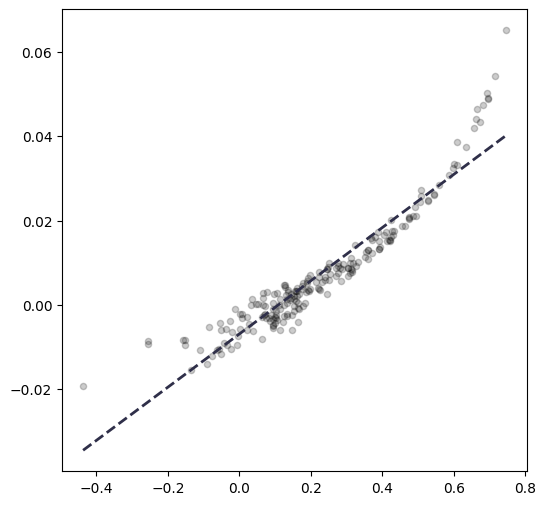

In [3]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
sns.regplot(x=loadings_1['Factor1'].values, 
            y=loadings_2['AD'].values, 
            ax=ax, 
            color='black',
            ci=None,
            # x_jitter=0.01,
            # y_jitter=0.01,
            scatter_kws={'s':20, 'alpha': 0.2},
            line_kws={'linewidth':2, 'linestyle': '--', 'color': '#2F2F49'});

#### Define breakpoints in the column list: the column index where a new subscale begins

In [4]:
def extract_scale_breaks(dataframe):

    # Assumes a "clean" dataframe with only the questionnaire items by item
    # Naming convention: scale name before underscore

    # Get a list of all column names
    column_names = dataframe.columns.tolist()

    # Tokenize each column name into unique substrings
    tokens = [name.split('_') for name in column_names]

    # Retrieve individual scales 
    a = [tokens[i][0] for i in np.arange(len(tokens))]
    indexes = np.unique(a, return_index=True)[1]
    scales = [a[index] for index in sorted(indexes)]

    # Get breakpoints
    scales_repeated = [tokens[i][0] for i in np.arange(len(tokens))]
    scale_breaks = [i for i in range(1,len(scales_repeated)) if scales_repeated[i]!=scales_repeated[i-1]]

    output = {'colnames': column_names,
              'scales': scales,
              'scales_repeated': scales_repeated,
              'breaks': [0] + scale_breaks + [len(tokens)+1]}

    return output

output = extract_scale_breaks(quest_data_sample)
print(output['scales'])
print(output['breaks'])

['SCZ', 'OCI', 'EAT', 'AES', 'AUDIT', 'SDS', 'STAI', 'BIS', 'LSAS']
[0, 43, 61, 87, 105, 115, 135, 155, 185, 210]


#### Re-order items 

In [5]:
# Spell out scale names
scale_names = {'SCZ': 'Schizotypy',
               'OCI': 'OCD',
               'EAT': 'Eating Disorders',
               'AES': 'Apathy',
               'AUDIT': 'Alcohol Misuse',
               'SDS': 'Depression',
               'STAI': 'Trait Anxiety',
               'BIS': 'Impulsivity',
               'LSAS': 'Social Anxiety'}

# Do the reverse mapping
scale_names_inverted = {v: k for k, v in scale_names.items()}

# Change scale order
x = ['Eating Disorders',
               'Impulsivity',
               'OCD',
               'Alcohol Misuse',
               'Schizotypy',
               'Depression',
               'Trait Anxiety',
               'Apathy',
               'Social Anxiety']

new_scale_order = [scale_names_inverted.get(key) for key in x]
new_scale_order

['EAT', 'BIS', 'OCI', 'AUDIT', 'SCZ', 'SDS', 'STAI', 'AES', 'LSAS']

In [6]:
def reorder_items(dataframe, new_order):

    D = []

    for string_to_match in new_order:

        matching_columns = [col for col in quest_data_sample.columns if col.startswith(string_to_match)]
        matching_column_indices = [quest_data_sample.columns.get_loc(col) for col in matching_columns]

        D.append(dataframe[matching_columns])

        dataframe_r = pd.concat(D, axis=1)
        
    return dataframe_r

quest_data_sample_r = reorder_items(quest_data_sample, new_scale_order)

# Re-extract labels
output_r = extract_scale_breaks(quest_data_sample_r)
print(output_r['scales'])
print(output_r['breaks'])

['EAT', 'BIS', 'OCI', 'AUDIT', 'SCZ', 'SDS', 'STAI', 'AES', 'LSAS']
[0, 26, 56, 74, 84, 127, 147, 167, 185, 210]


## 2. Compute and plot correlation matrix

In [7]:
## Mask non-significant p-values
def r_pvalues(df):
    cols = pd.DataFrame(columns=df.columns)
    p = cols.transpose().join(cols, how='outer')
    for r in df.columns:
        for c in df.columns:
            tmp = df[df[r].notnull() & df[c].notnull()]
            p[r][c] = round(spearmanr(tmp[r], tmp[c])[1], 4)
    return p

In [8]:
## Compute correlation matrix
cormat = quest_data_sample_r.corr(method='spearman')
cor_p_values = r_pvalues(quest_data_sample_r)

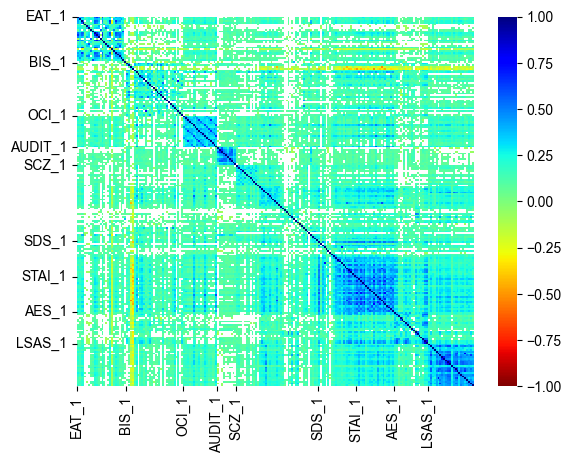

In [15]:
## Plot
fig, ax = plt.subplots(1,1)
sns.heatmap(cormat, cmap='jet_r', 
            mask = cor_p_values.values > 0.05,
            vmin=-1,
            vmax=1);
ax.set_xticks(output_r['breaks'][:-1])
ax.set_yticks(output_r['breaks'][:-1])
ax.set_xticklabels(labels=[output_r['colnames'][i] for i in output_r['breaks'][:-1]], fontsize=10)
ax.set_yticklabels(labels=[output_r['colnames'][i] for i in output_r['breaks'][:-1]], fontsize=10)
cor_p_values
sns.set_style('white')

## 3. Plot loadings

In [16]:
loadings_1 = loadings_1.rename(columns={"Unnamed: 0": "Item"})
loadings_1['Scale'] = output['scales_repeated']
loadings_1['Domain_name'] = [scale_names[i] for i in output['scales_repeated']]
loadings_1

,Item,Factor1,Factor2,Factor3,Scale,Domain_name
0,SCZ_1,0.159947,0.323075,0.084666,SCZ,Schizotypy
1,SCZ_2,0.142909,0.325668,0.116402,SCZ,Schizotypy
2,SCZ_3,0.093733,0.282540,0.003894,SCZ,Schizotypy
3,SCZ_4,0.071397,0.272681,0.011396,SCZ,Schizotypy
4,SCZ_5,0.006786,0.232739,-0.021182,SCZ,Schizotypy
...,...,...,...,...,...,...
204,LSAS_20,0.093822,0.069709,0.646947,LSAS,Social Anxiety
205,LSAS_21,0.197618,0.072887,0.581424,LSAS,Social Anxiety
206,LSAS_22,0.132151,0.271918,0.519986,LSAS,Social Anxiety
207,LSAS_23,0.163735,0.112778,0.629701,LSAS,Social Anxiety


#### Re-order items in loadings dataframe

In [17]:
def reorder_items_loadings(dataframe, new_order):

    D = []

    for string_to_match in new_order:

        mask = dataframe['Item'].str.startswith(string_to_match)
        D.append(dataframe.iloc[dataframe[mask].index])
  
    dataframe_r = pd.concat(D, axis=0)

    return dataframe_r

loadings_1_r = reorder_items_loadings(loadings_1, new_scale_order)
loadings_1_r.head(5)


,Item,Factor1,Factor2,Factor3,Scale,Domain_name
61,EAT_1,0.086895,0.463394,0.181666,EAT,Eating Disorders
62,EAT_2,0.102079,0.434815,0.074425,EAT,Eating Disorders
63,EAT_3,0.132900,0.482250,0.202498,EAT,Eating Disorders
64,EAT_4,0.162792,0.522136,0.145023,EAT,Eating Disorders
65,EAT_5,-0.083752,0.198456,0.009710,EAT,Eating Disorders


#### Create a color palette

In [18]:
# The number of colors here should match the number of scales
cols = ['#00FFFF',
        '#FF00FF',
        '#87CEEB',
        '#FFA500',
        '#EADDCA',
        '#50c878',
        '#CC7722',
        '#000080',
        '#800080'
        ]

# Grab colors in proportion to number of items in each scale
col_repeats = Counter(output_r['scales_repeated']).values()
def repeat_elements(main_list, repeat_list):
    repeated_list = [item for item, repeat_count in zip(main_list, repeat_list) for _ in range(repeat_count)]
    return repeated_list
colors = repeat_elements(cols, col_repeats)

/Users/angelaradulescu/Dropbox/Princeton/Research/moat/scripts/moat-online/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/angelaradulescu/Dropbox/Princeton/Research/moat/scripts/moat-online/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/angelaradulescu/Dropbox/Princeton/Research/moat/scripts/moat-online/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/angelaradulescu/Dropbox/

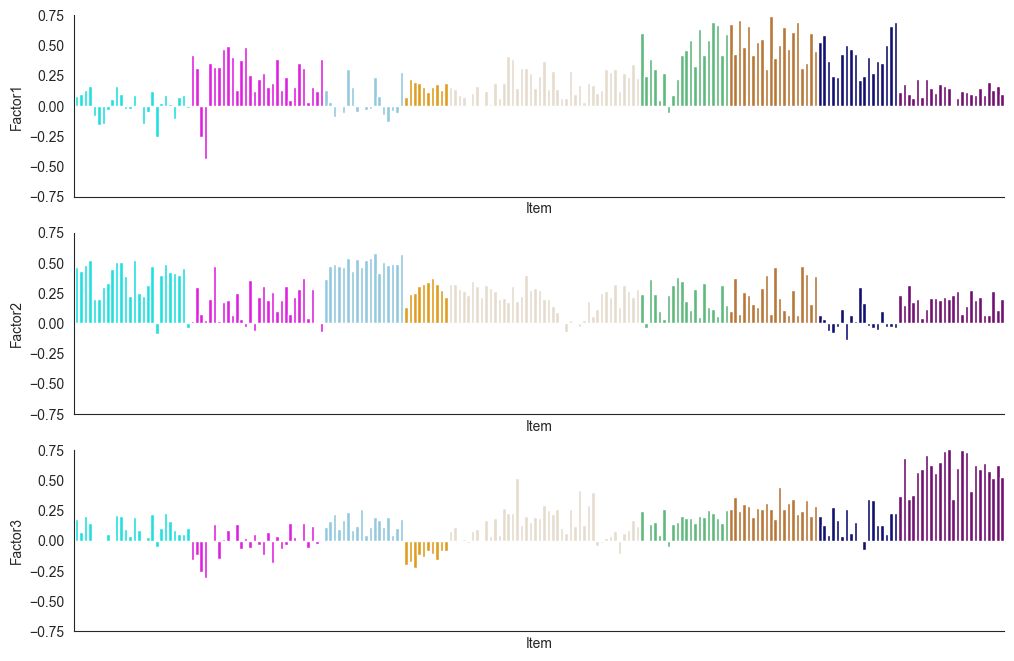

In [19]:
fig, ax = plt.subplots(3,1, figsize=(12,8))

sns.barplot(x='Item', 
            y='Factor1',
            data=loadings_1_r,
            ax=ax[0],
            palette=colors)
ax[0].set_ylim(-0.75,0.75)
ax[0].set_xticks([])

sns.barplot(x='Item', 
            y='Factor2',
            data=loadings_1_r,
            ax=ax[1],
            palette=colors)
ax[1].set_ylim(-0.75,0.75)
ax[1].set_xticks([])

sns.barplot(x='Item', 
            y='Factor3',
            data=loadings_1_r,
            ax=ax[2],
            palette=colors)
ax[2].set_ylim(-0.75,0.75)
ax[2].set_xticks([])

sns.despine();
sns.set_style('white');

## 4. Plot factor score distribution

In [22]:
scores_long = pd.melt(scores, value_vars=['Factor1', 'Factor2', 'Factor3'], id_vars=['subject'])
scores_long.head(10)

,subject,variable,value
0,subj1,Factor1,0.389093
1,subj2,Factor1,-0.035653
2,subj3,Factor1,-1.016967
3,subj4,Factor1,-0.557183
4,subj5,Factor1,1.112859
5,subj6,Factor1,-0.962984
6,subj7,Factor1,-0.920058
7,subj8,Factor1,-0.499581
8,subj9,Factor1,0.121388
9,subj10,Factor1,-0.266658


/Users/angelaradulescu/Dropbox/Princeton/Research/moat/scripts/moat-online/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/angelaradulescu/Dropbox/Princeton/Research/moat/scripts/moat-online/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/angelaradulescu/Dropbox/Princeton/Research/moat/scripts/moat-online/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/angelaradulescu/Dropbox/

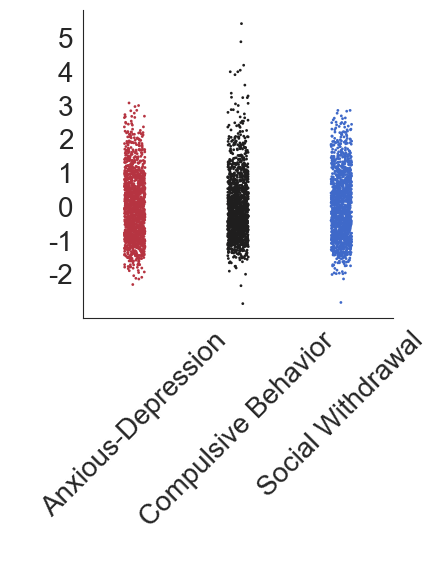

In [23]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
sns.stripplot(data=scores_long, 
              x="variable", 
              y="value", 
              palette='icefire_r', 
              size=2,
              ax=ax)

ax.set_xlabel(' ', fontsize=25);
ax.set_ylabel(' ', fontsize=25);
ax.set_xticklabels(['Anxious-Depression','Compulsive Behavior', 'Social Withdrawal'], fontsize=20);
ax.set_yticks([-2, -1, 0, 1, 2, 3, 4, 5])
ax.set_yticklabels([-2, -1, int(0), 1, 2, 3, 4, 5], fontsize=20)
plt.xticks(rotation=45)
sns.despine();
sns.set_style('white');